## Data Munging

In [1]:
# Load the required packages
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

import re 
from wordcloud import STOPWORDS, WordCloud

%matplotlib inline
sns.set_style('darkgrid')

In [2]:
# Load the datasets
albums = pd.read_csv("Data/albums.csv")
bands = pd.read_csv("Data/bands.csv")
reviews = pd.read_csv("Data/reviews.csv")

In [3]:
# Review the dataframes
display(albums.head())
print(albums.shape)
print(albums.info())

display(bands.head())
print(bands.shape)
print(bands.info())

display(reviews.head())
print(reviews.shape)
print(reviews.info())

id  band                                    title  year
0   1     1                           Taste the Hate  2014
1   2     3                     The Bringer of Death  2014
2   3     4  Deception| Calculate What You Can't See  2005
3   4     7                              Inti Huacay  1998
4   5     7                         Génesis & horror  2002

(28069, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28069 entries, 0 to 28068
Data columns (total 4 columns):
id       28069 non-null int64
band     28069 non-null int64
title    28069 non-null object
year     28069 non-null int64
dtypes: int64(3), object(1)
memory usage: 877.2+ KB
None


id                name        country    status  formed_in        genre  \
0   1          ('M') Inc.  United States   Unknown     2009.0  Death Metal   
1   2               (sic)  United States  Split-up     1993.0  Death Metal   
2   3           .F.O.A.D.         France    Active     2009.0  Death Metal   
3   4            100 Suns  United States    Active     2004.0  Death Metal   
4   5  12 Days of Anarchy  United States  Split-up     1998.0  Death Metal   

            theme        active  
0             NaN        2009-?  
1             NaN     1993-1996  
2  Life and Death  2009-present  
3             NaN  2004-present  
4         Anarchy     1998-2002

(37723, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37723 entries, 0 to 37722
Data columns (total 8 columns):
id           37723 non-null int64
name         37723 non-null object
country      37723 non-null object
status       37723 non-null object
formed_in    33392 non-null float64
genre        37723 non-null object
theme        20179 non-null object
active       33796 non-null object
dtypes: float64(1), int64(1), object(6)
memory usage: 2.3+ MB
None


id  album                                   title  score  \
0   1      4      The Killer Count Just Keeps Rising   0.88   
1   2      5   A gem of heterogeneous death metal...   0.96   
2   3      8  Fantasic| if mostly for its influences   0.83   
3   4     45                 A rare| lost hidden gem   0.80   
4   5     54    Pure| but flayed and covered in soot   0.92   

                                             content  
0  When I first threw this on I really didnt know...  
1  Several years ago I bought from a band member|...  
2  What a wonderful release this is. ‘Vox Fatum’ ...  
3  Picture this: crushing| brutal death metal| wi...  
4  Abhordium's When Depravity Incarnates is an ex...

(21510, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21510 entries, 0 to 21509
Data columns (total 5 columns):
id         21510 non-null int64
album      21510 non-null int64
title      21510 non-null object
score      21510 non-null float64
content    21510 non-null object
dtypes: float64(1), int64(2), object(2)
memory usage: 840.3+ KB
None


#### Renaming the dataset columns

In [4]:
# For my own convinience, I renamed the dataframe columns
albums.columns = ['Album ID', 'Band ID', 'Album Title', 'Year Released']
bands.columns = ['Band ID', 'Band Name', 'Country', 'Status', 'Year Formed', 'Genre', 'Lyrical Theme', 'Years Active']
reviews.columns = ['Review ID', 'Album ID', 'Review Title', 'Score', 'Review']

display(albums.head(1))
display(bands.head(1))
display(reviews.head(1))

Album ID  Band ID     Album Title  Year Released
0         1        1  Taste the Hate           2014

Band ID   Band Name        Country   Status  Year Formed        Genre  \
0        1  ('M') Inc.  United States  Unknown       2009.0  Death Metal   

  Lyrical Theme Years Active  
0           NaN       2009-?

Review ID  Album ID                        Review Title  Score  \
0          1         4  The Killer Count Just Keeps Rising   0.88   

                                              Review  
0  When I first threw this on I really didnt know...

#### Parsing the Genre Column

Many bands fall into multiple genres. As it stands, these multiple genres are concatenated into a long string. We separate the genres and add a new band row for each distinct genre

In [5]:
dat = bands['Genre'].copy()
dat = dat.map(lambda bracket: re.sub("[\(\[].*?[\)\]]", "", bracket))
dat = dat.map(lambda word: word.title())
dat = dat.map(lambda word: word.split(" | "))
bands['Genre'] = dat
df = bands[['Genre', 'Band ID']]

df.reset_index(inplace=True)
rows = []
_ = df.apply(lambda row: [rows.append([row['Band ID'], row['Genre'], nn]) 
                         for nn in row.Genre], axis=1)
df = pd.DataFrame(rows, columns=['Band ID', 'x', 'Genre'])
bands = bands.drop('Genre', axis=1).merge(df.drop('x', axis=1), how='outer', on='Band ID')

#### Check for missing data

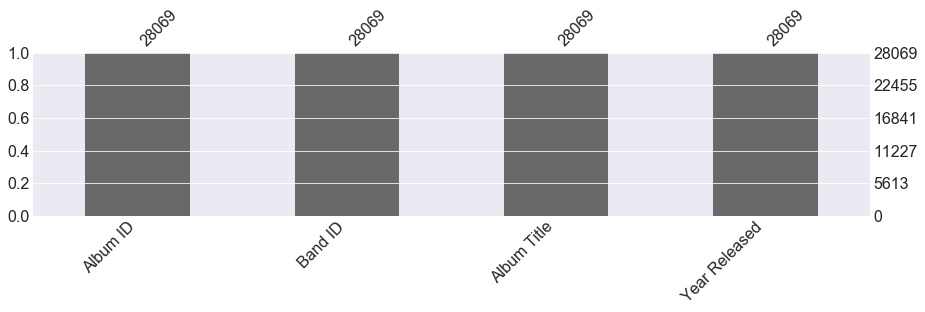

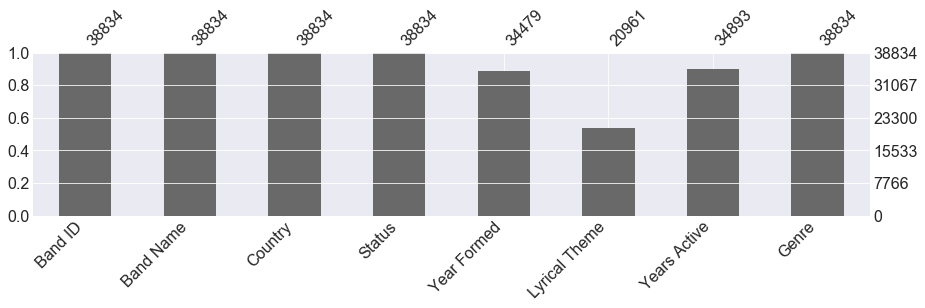

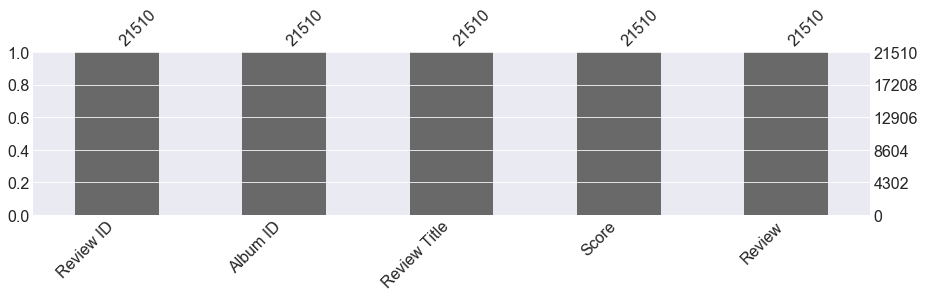

In [6]:
display(msno.bar(albums, figsize=(15,3)))
display(msno.bar(bands, figsize=(15,3)))
display(msno.bar(reviews, figsize=(15,3)))

The albums and reviews datasets contain no missing values, but the bands dataset do. 

* The "Lyrical Theme" column represents the lyrical theme of the band, which will not be examined in the analysis.

* The second column with missing values is the "Year Formed", representing the year the band was founded. 
    * This may prove to be problematic and we might have to remove the associated albums & reviews for the particular missing bands
    * The data is also stored as a float due to the presence of NaN/missing values

## Let the Analysis Begin

### Number of albums over the years

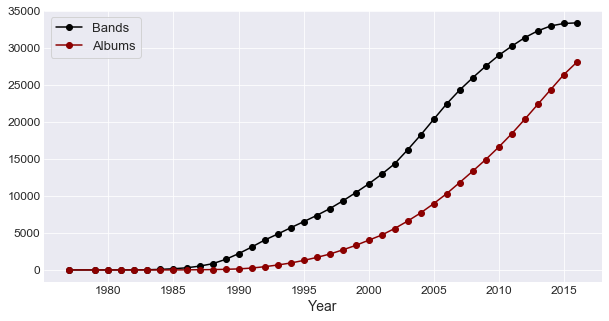

In [7]:
total_albums_by_year = albums[['Album ID', 'Year Released']].groupby('Year Released').count().cumsum()
total_albums_by_year['Year'] = total_albums_by_year.index

total_bands_by_year = bands[['Band ID', 'Year Formed']].drop_duplicates(['Band ID']).groupby('Year Formed').count().cumsum()
total_bands_by_year['Year'] = total_bands_by_year.index.astype(int)

bands_albums_total = total_bands_by_year.merge(total_albums_by_year, how='outer')
bands_albums_total.columns = ['Bands', 'Year', 'Albums']
bands_albums_total.fillna(0, inplace=True)
bands_albums_total.drop(bands_albums_total.index[-1], inplace=True)

plt.figure(figsize=(10,5))
plt.plot('Year', 'Bands', data=bands_albums_total, linestyle='-', marker='o', color='black')
plt.plot('Year', 'Albums', data=bands_albums_total, linestyle='-', marker='o', color='darkred')
plt.legend(labels = ['Bands', 'Albums'], fontsize=13, loc="upper left", frameon=True)
plt.xlabel('Year', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Interestingly, there are more bands than albums. Somewhat unintuitive since bands usually release several albums.

### Number of album releases each year

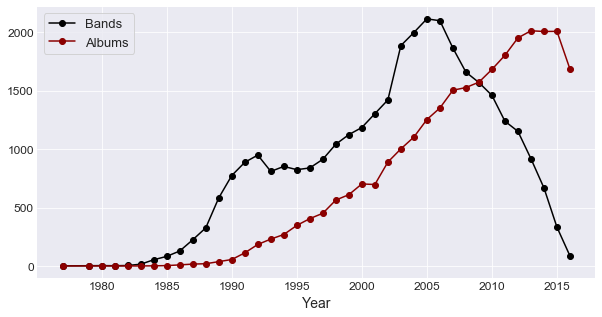

In [8]:
yearly_albums_by_year = albums[['Album ID', 'Year Released']].groupby('Year Released').count()
yearly_albums_by_year['Year'] = total_albums_by_year.index

yearly_bands_by_year = bands[['Band ID', 'Year Formed']].drop_duplicates(['Band ID']).groupby('Year Formed').count()
yearly_bands_by_year['Year'] = total_bands_by_year.index.astype(int)

bands_albums_by_year = yearly_bands_by_year.merge(yearly_albums_by_year, how='outer')
bands_albums_by_year.columns = ['Bands', 'Year', 'Albums']
bands_albums_by_year.fillna(0, inplace=True)
bands_albums_by_year.drop(bands_albums_by_year.index[-1], inplace=True)

plt.figure(figsize=(10,5))
plt.plot('Year', 'Bands', data=bands_albums_by_year, linestyle='-', marker='o', color='black')
plt.plot('Year', 'Albums', data=bands_albums_by_year, linestyle='-', marker='o', color='darkred')
plt.legend(labels = ['Bands', 'Albums'], fontsize=13, loc="upper left", frameon=True)
plt.xlabel('Year', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

As production and distribution gets cheaper over the years, record labels are less likely to sign more bands but pump out more albums from the select few bands

## The Many Faces of Metal

Let's examine the different sub-genres in the metal umbrella

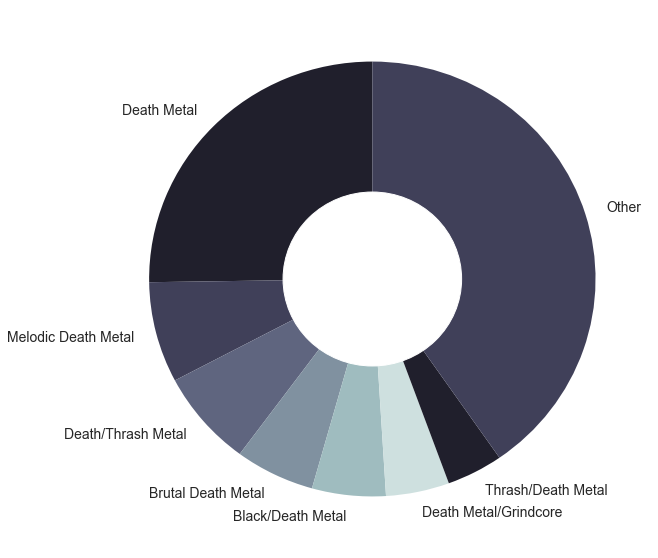

In [9]:
genre_counts = bands['Genre'].value_counts()
genre_percent = bands['Genre'].value_counts()/(bands['Genre'].count())*100
genre_cumsum_percent = genre_percent.cumsum()
genre_df = pd.concat([genre_counts, genre_percent, genre_cumsum_percent], axis=1)
genre_df.columns=['Counts', "Percent", "Cumulative Percent"]

genre_subsets = genre_df.head(7)
Other = [(sum(bands['Genre'].value_counts())-sum(genre_subsets['Counts'])),
                      (100-sum(genre_subsets['Percent'])), 100.]
Other = pd.DataFrame([Other], columns=['Counts', "Percent", "Cumulative Percent"], index=['Other'])
genre_subsets = genre_subsets.append(Other)

sns.set_palette("bone")
plt.figure(figsize=(10,10))
plt.rcParams['font.size'] = 14
my_circle=plt.Circle( (0,0), 0.4, color='white')
plt.pie(genre_subsets['Counts'], labels=genre_subsets.index, startangle=90)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

Apparently there is a difference between "Death/Thrash Metal" and "Thrash/Death Metal"... and apparently the former is more popular than the latter

### Number of Albums per genre per year

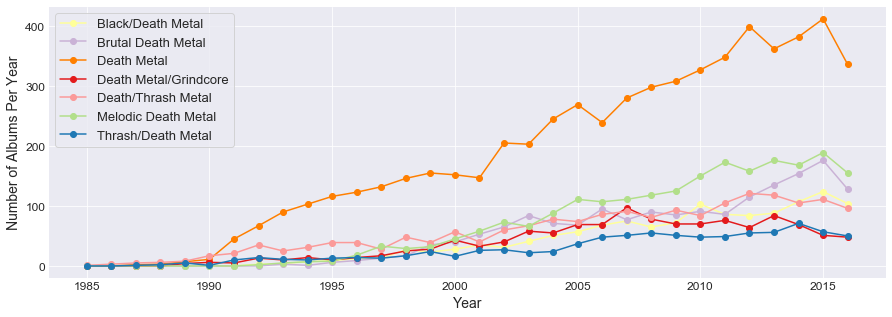

In [10]:
albums_band = bands.merge(albums, how='outer', on='Band ID')
albums_band = albums_band.loc[albums_band['Genre'].isin(genre_subsets.index)]
albums_by_genre_year = albums_band.groupby(["Year Released", "Genre"])["Album ID"].count().unstack("Genre").fillna(0)
albums_by_genre_year.drop(albums_by_genre_year.index[-1], inplace=True)


sns.set_palette('Paired_r', n_colors = 7)
plt.figure(figsize=(15,5))
plt.plot(albums_by_genre_year, marker='o', linestyle='-')
plt.legend(labels = list(albums_by_genre_year.columns), fontsize=13, loc="upper left", frameon=True)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Albums Per Year', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

"Death Metal" is and always has been the most popular genre of Metal.

### Average album score by genre
We only include albums with more than 10 reviews

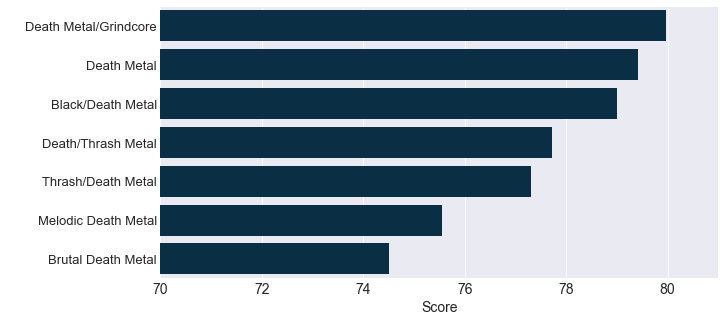

In [11]:
albums_band_review = albums_band.merge(reviews, how='outer', on='Album ID')
albums_band_review = albums_band_review[np.isfinite(albums_band_review['Score'])]
genre_review_counts = albums_band_review[['Genre', 'Review']].groupby('Genre').count()
average_genre_score = albums_band_review[['Genre', 'Score']].groupby('Genre').mean()*100
average_genre_score = pd.concat([average_genre_score, genre_review_counts], axis=1)
average_genre_score.sort_values('Score', ascending=False, inplace=True)
average_genre_score = average_genre_score[average_genre_score['Review'] > 10]

plt.figure(figsize=(10,5))
ax = sns.barplot(average_genre_score['Score'], average_genre_score.index, color="#00304e")
ax.set_ylabel(" ")
ax.set_yticklabels(labels=list(average_genre_score.index),fontsize=13)
ax.set_xlim(70,81)
plt.show()

### What albums are the most critically acclaimed

In [12]:
average_album_score = reviews[['Album ID', 'Score']].groupby('Album ID').mean()*100
reviews_per_album = reviews[['Album ID', 'Review ID']].groupby('Album ID').count()

acclaimed_albums = average_album_score.join(reviews_per_album, how='outer')
acclaimed_albums['Album ID'] = acclaimed_albums.index
acclaimed_albums.columns = ['Score', 'Number of Reviews', 'Album ID']

albums_band = bands.merge(albums, how='outer', on='Band ID')
acclaimed_albums = acclaimed_albums.merge(albums_band, how='outer', on='Album ID')
acclaimed_albums = acclaimed_albums[['Score', 'Number of Reviews', 'Album Title', 'Band Name', 'Genre']]
acclaimed_albums = acclaimed_albums[acclaimed_albums['Number of Reviews'] > 10]
acclaimed_albums.sort_values('Score', ascending=False, inplace=True)

acclaimed_albums['Plot Text'] = acclaimed_albums['Album Title'] + ' (' + acclaimed_albums['Band Name'] + ')'
top_20_acclaimed_albums = acclaimed_albums.head(20)

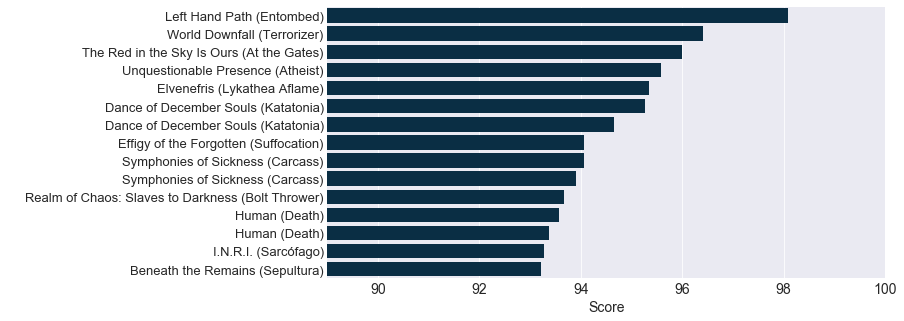

In [13]:
plt.figure(figsize=(10,5))
ax = sns.barplot(top_20_acclaimed_albums['Score'], top_20_acclaimed_albums['Plot Text'], color="#00304e")
ax.set_ylabel(" ")
ax.set_yticklabels(labels=list(top_20_acclaimed_albums['Plot Text']),fontsize=13)
ax.set_xlim(89,100)
plt.show()

### Most acclaimed genre
We limited the scores to albums who received more than 10 reviews, and determined the highest average scoring genre with more than 5 albums in the genre

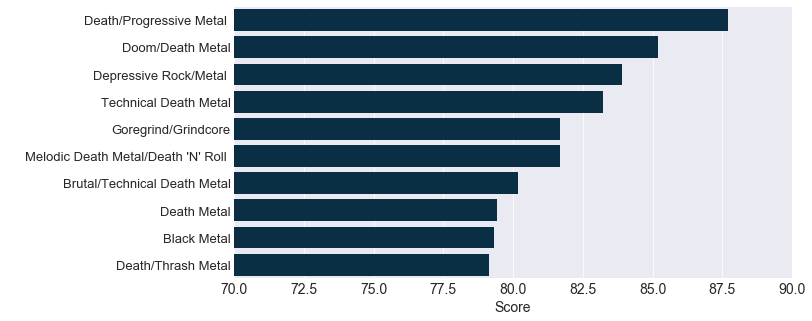

In [14]:
reviewed_albums_by_genre = acclaimed_albums[['Score', 'Genre']].groupby('Genre').count()
reviewed_albums_by_genre.columns = ['Number of Albums']
reviewed_albums_by_genre = reviewed_albums_by_genre[reviewed_albums_by_genre['Number of Albums'] > 5]
reviewed_albums_by_genre['Genre'] = reviewed_albums_by_genre.index
reviewed_albums_by_genre = acclaimed_albums.merge(reviewed_albums_by_genre, on='Genre', how='right')
average_genre_score = reviewed_albums_by_genre[['Score', 'Genre']].groupby('Genre').mean().sort_values('Score', ascending=False).head(10)
average_genre_score

plt.figure(figsize=(10,5))
ax = sns.barplot(average_genre_score['Score'], average_genre_score.index, color="#00304e")
ax.set_ylabel(" ")
ax.set_yticklabels(labels=list(average_genre_score.index),fontsize=13)
ax.set_xlim(70,90)
plt.show()

Since there is no hard barrier to entry, the more albums a genre has, the more likely it is to be diluted by less-than-stelar albums. 

### Is Metal Racist?
<img src="Images/Diversityklok.png" align="left" style="width: 500px;"/>


In [15]:
import plotly.plotly as py
import plotly.graph_objs as go 
import cufflinks as cf

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
cf.go_offline()

In [16]:
country_codes = pd.read_html("http://www.nationsonline.org/oneworld/country_code_list.htm")[2]
country_codes = country_codes.drop([0,1]).drop([0,2,4],axis=1)
country_codes.columns=['Country','Code']

bands_by_country = bands[['Country', 'Band ID']].groupby('Country').count()
bands_by_country.columns = ['Number of Bands']
bands_by_country['Country'] = bands_by_country.index

bands_by_country = pd.merge(bands_by_country, country_codes, how='left', on='Country')
bands_by_country.sort_values('Number of Bands', ascending=False, inplace=True)

missing = bands_by_country[bands_by_country.isnull().any(axis=1)].copy()
missing['Code'] = ['USA', 'RUS', 'NaN','VEN', 'KOR', 'MKD', 'TWN', 'IRN', 'BRN', 'VNM', 'NaN','SYR', 'REU', 'LAO', 'ALA', 'NaN']
bands_by_country.update(missing, join='left')
bands_by_country['Number of Bands'] = bands_by_country['Number of Bands'].astype(int)
bands_by_country['Country'] = bands_by_country['Country'].astype(str)
bands_by_country['Flavor Text'] = bands_by_country['Country'] + "<br>" + bands_by_country['Number of Bands'].map(str) + " Bands"
bands_by_country.head()

Number of Bands        Country Code                  Flavor Text
128             8055  United States  USA  United States<br>8055 Bands
42              3415        Germany  DEU        Germany<br>3415 Bands
60              1685          Italy  ITA          Italy<br>1685 Bands
115             1644         Sweden  SWE         Sweden<br>1644 Bands
19              1622         Brazil  BRA         Brazil<br>1622 Bands

In [17]:
data = dict(type='choropleth',
            locations = bands_by_country['Code'],
            z = bands_by_country['Number of Bands'],
            text = bands_by_country['Flavor Text'],
            colorbar = {'title': 'Number of Metal Bands'},
            colorscale= 'viridis',
            hoverinfo = "text"          
)

layout = dict(
    title = 'World Map of Number of Metal Bands',
    autosize=False,
    width=900,
    height=800,
    geo = dict(
        showframe = False,
        projection = {'type':'orthographic'},
        showlakes = True,
        lakecolor = 'rgb(255, 255, 255)',
        showcountries=True,
        countrycolor = "grey",
        oceancolor = 'rgb(0,0,52)'
    )
)

choromap = go.Figure(data = [data],layout = layout)
#iplot(choromap)

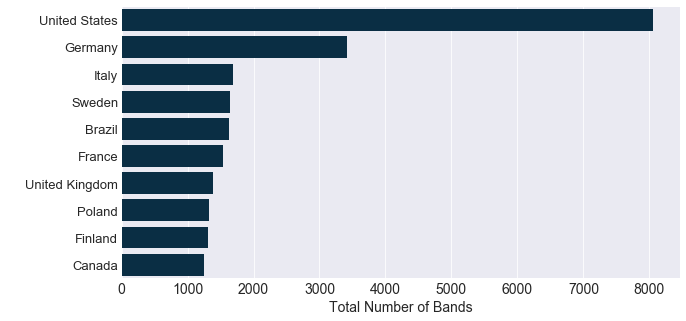

In [18]:
bands_by_country_df= bands_by_country.iloc[0:10].drop('Code', axis=1)
plt.figure(figsize=(10,5))
ax = sns.barplot(bands_by_country_df['Number of Bands'], bands_by_country_df['Country'], color="#00304e")
plt.xlabel('Total Number of Bands', axes=ax)
ax.set_ylabel(" ")
ax.set_yticklabels(labels=list(bands_by_country_df['Country']),fontsize=13)
plt.show()

Generally thought of as being popular in Scandinavian countries, we see very few bands coming out of that region relative to other countries. However, this may be an effect of the countries' population size.

To account for this, we will calculate the number of bands per capita

#### Number of Metal Bands Per Capita

In [19]:
def remove_whitespaces(strings):
    x = " ".join(strings.split())
    return x

country_population = pd.read_csv('Data/Country Populations.csv', encoding = "ISO-8859-1", header=-1)
country_population.columns = ['Rank', 'Country', 'Continent', 'Region', 'Population_2016', 'Population_2017', 'Percent Change']
country_population['Country'].map(lambda line: str(line.lstrip()))

country_population['Country'] = country_population['Country'].apply(remove_whitespaces)

bands_per_capita = pd.merge(bands_by_country, country_population, how='outer', on='Country')
bands_per_capita = bands_per_capita[-bands_per_capita.isnull().any(axis=1)]
bands_per_capita['Population_2017'] = bands_per_capita['Population_2017'].str.replace(",","").map(int)
bands_per_capita['Bands Per Capita'] = ((bands_per_capita['Number of Bands'].map(int))/(bands_per_capita['Population_2017'].map(int)))*100000
bands_per_capita['Bands Per Capita'] = round(bands_per_capita['Bands Per Capita'],1)
bands_per_capita['Flavor Text'] = bands_per_capita['Country'] + "<br>" + bands_per_capita['Bands Per Capita'].map(str) + " Bands Per 100,000 People"

data = dict(type='choropleth',
            locations = bands_per_capita['Code'],
            z = bands_per_capita['Bands Per Capita'],
            text = bands_per_capita['Flavor Text'],
            colorbar = {'title': 'Number of Metal Bands Per 100,000 People'},
            colorscale = 'viridis',
            hoverinfo = "text"
)

layout = dict(
    title = 'World Map of Number of Metal Bands Per 100,000 People',
    autosize=False,
    width=900,
    height=800,
    geo = dict(
        showframe = False,
        projection = {'type':'orthographic'},
        showlakes = True,
        lakecolor = 'rgb(255, 255, 255)',
        showcountries = True,
        countrycolor = "grey",
        oceancolor = 'rgb(0,0,52)'
    )
)

choromap = go.Figure(data = [data],layout = layout)
iplot(choromap)

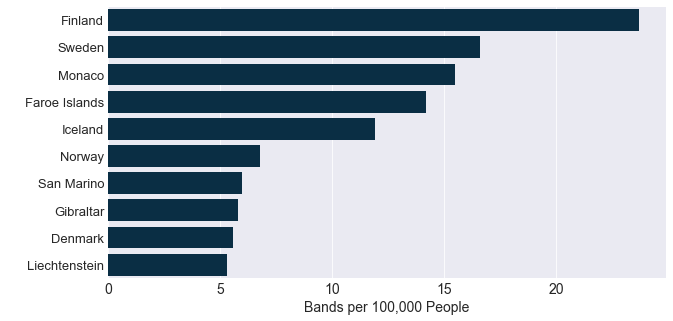

In [20]:
bands_per_capita_df = bands_per_capita.sort_values(['Bands Per Capita'], ascending=False).head(10)
plt.figure(figsize=(10,5))
ax = sns.barplot(bands_per_capita_df['Bands Per Capita'], bands_per_capita_df['Country'], color="#00304e")
plt.xlabel('Bands per 100,000 People', axes=ax)
ax.set_ylabel(" ")
ax.set_yticklabels(labels=list(bands_per_capita_df['Country']),fontsize=13)
plt.show()

After adjusting for population size, we see 

### Is All Death Metal Satanic?

In [21]:
def parse_words(words):
    x = words.dropna().str.replace("|", " ").values.tolist()
    x = list(map(lambda word: word.title().split(),x))
    return x

def genre_corpus(genre):
    cloud = WordCloud(stopwords=STOPWORDS,background_color = 'black', width=800, height=400,collocations=False).generate(' '.join(str(r) for v in parse_words(bands[bands.Genre == genre]['Lyrical Theme']) for r in v))
    plt.figure(figsize=(15,7))
    plt.imshow(cloud,cmap='bone_r', alpha=0.9)
    plt.axis('off')
    return plt.show()

#### Overall Word Cloud for All Genres

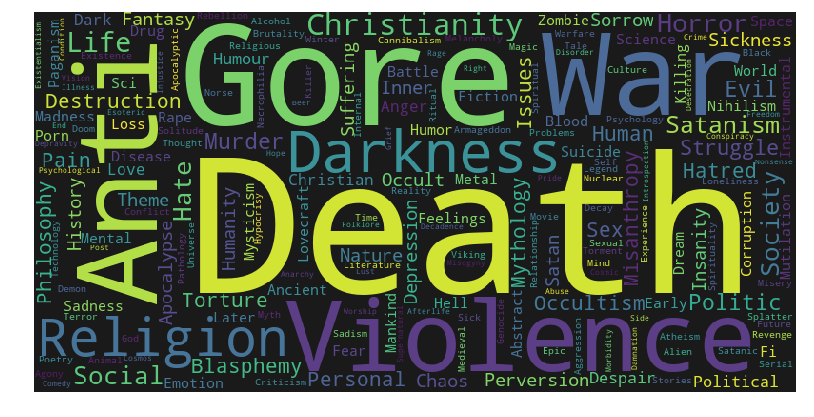

In [22]:
overall_cloud = WordCloud(stopwords=STOPWORDS,background_color = 'black', width=800, height=400,collocations=False).generate(' '.join(str(r) for v in parse_words(bands['Lyrical Theme']) for r in v))

plt.figure(figsize=(15,7))
plt.imshow(overall_cloud,cmap='bone_r', alpha=0.9)
plt.axis('off')
plt.show()

#### Wordclouds for each genre

Melodic Death Metal

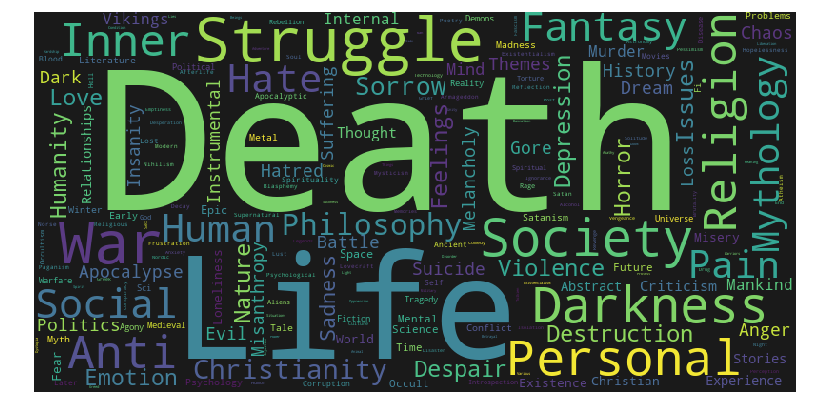

In [23]:
genre_corpus("Melodic Death Metal")

Brutal Death Metal

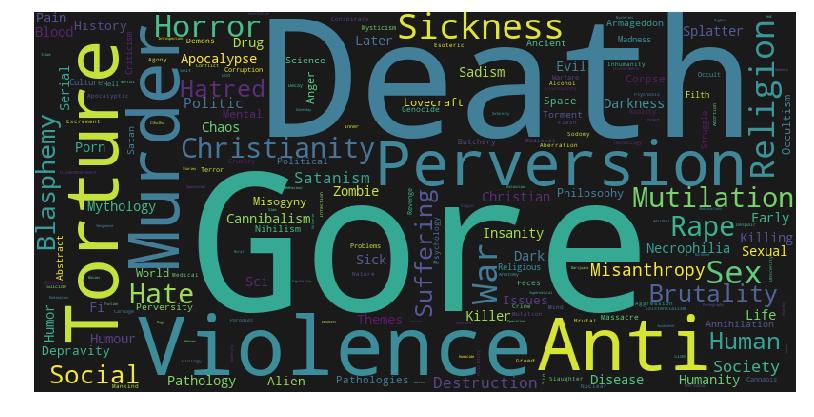

In [24]:
genre_corpus("Brutal Death Metal")

Death/Thrash Metal

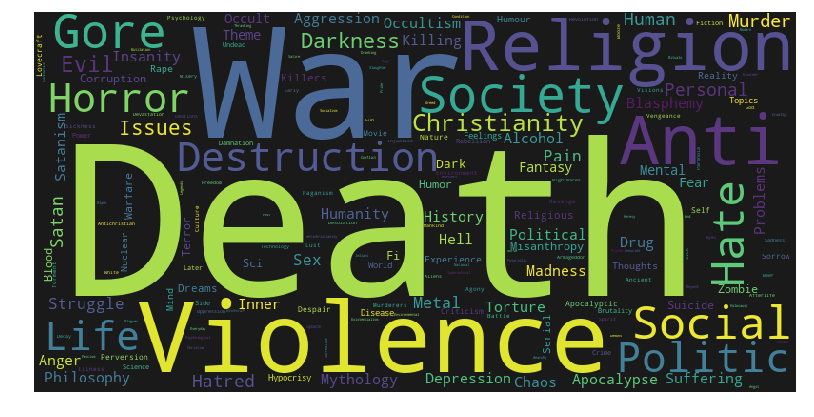

In [25]:
genre_corpus("Death/Thrash Metal")

Death Metal/Grindcore: The Genre with the Highest Average Album Score

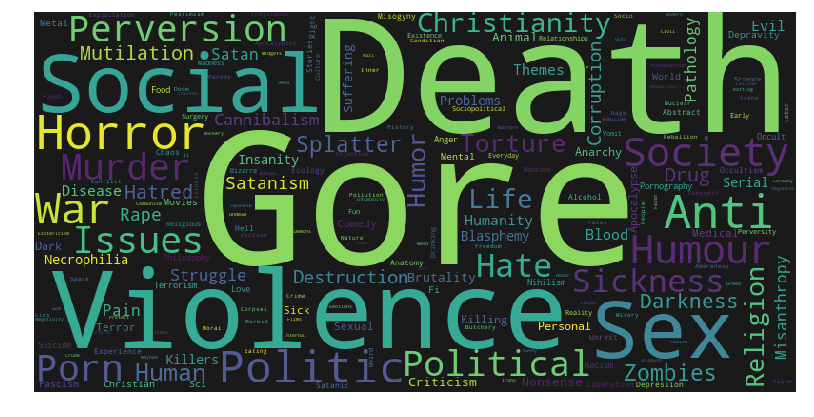

In [26]:
genre_corpus("Death Metal/Grindcore")

Death/Progressive Metal: The Most Acclaimed Genre

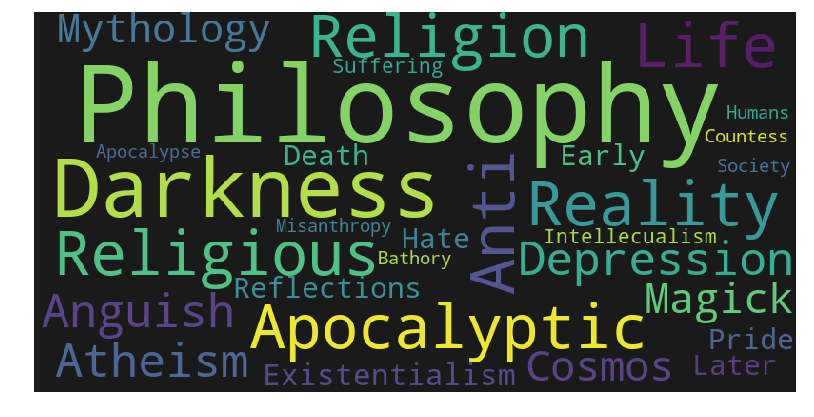

In [27]:
genre_corpus('Death/Progressive Metal')

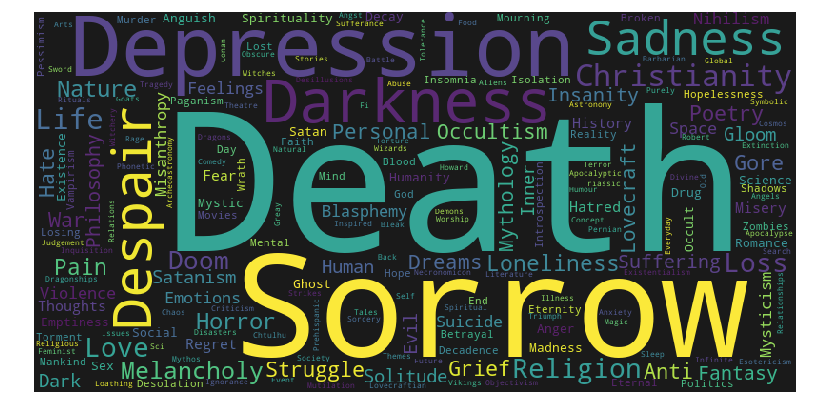

In [28]:
genre_corpus('Doom/Death Metal')

To nobody's surprise, the common themes of metal genre seem to be Death, Gore, and Violence. And yet, metalheads seem to be some of the friendliest people. Maybe it's cathartic?